# Development of TDI filter
Some aPCI studies will may want as a diagnostic, comparison, or reference, a representation of stencil that is applied by the TDI algorithm, or some approximant.  

## Reverse engineering the TDI stencil
We had tools that could be applied for this from ground up in the old pylisa code, but it would be most valuable to be able to match with the actual stencils used in pyTDI sometimes.   Getting all the conventions and details right can be hard.  I did not notice a straightforward way to get this stencil info from the pyTDI code functions, because that isn't really how the calculation is organized at least at top level.  Fortunately it should be straightforward to extract this from the pyTDI code as a black box by probing it's impulse response.

In [1]:
from pytdi.michelson import X1, Y1, Z1, X2, Y2, Z2
from pytdi import Data
import h5py
import numpy as np
import copy
import pcipy

datadir = "/data/jgbaker/software/pylisa/data/"
orbits = datadir+"keplerian-orbits.h5"
workdir = datadir+"/simulations/"
noise_file_base = "2025-07-01_19h38_laser_tm_oms_"
gw_file_base = "2025-07-01_19h34_"
dtpath = "2024-04-10_18h14_"

In [2]:
##This is the code for computing TDI as we do it in noise_simulation:
if 0:  #the code is just to look at
    data_noise = Data.from_instrument(instr)
    if args.tdi == '2':
        X, Y, Z = X2, Y2, Z2
    else:
        X, Y, Z = X1, Y1, Z1
    # Build other 2.0 Michelson variables
    X_data = X.build(**data_noise.args)
    Y_data = Y.build(**data_noise.args)
    Z_data = Z.build(**data_noise.args)
    # Apply TDI 2.0
    x_noise = X_data(data_noise.measurements)
    y_noise = Y_data(data_noise.measurements)
    z_noise = Z_data(data_noise.measurements)

In [3]:
# If we use a file
#simpath = workdir + dtpath + 'measurements_4Hz.h5'
simpath = workdir + noise_file_base + 'measurements_4Hz.h5'
# load hdf5 file to read data attrs
sim = h5py.File(simpath, 'r')

# load data
data_noise = Data.from_instrument(simpath)

fs = data_noise.fs

You are using a measurement file in a development version
You are using a measurement file in a version that might not be fully supported


In [4]:
# Build other 2.0 Michelson variables
X_data_op = X2.build(**data_noise.args)
Y_data_op = Y2.build(**data_noise.args)
Z_data_op = Z2.build(**data_noise.args)

X_n_orig=X_data_op(data_noise.measurements)

In [5]:

#Test that we can work-with and reconstruct measurements and TDI for shorter series
#REF measurements = {f'isi_{link}': dset[:,ilink] for ilink, link in enumerate(links)}
mosas_order = ['12', '23', '31', '13', '21', '32']

n=20000
n=2000
#make modified version of the data_noise args
newargs=copy.deepcopy(data_noise.args)
for k in newargs['delays'].keys():
    #print(k,newargs['delays'][k].shape,newargs['delay_derivatives'][k].shape)
    newargs['delays'][k]=newargs['delays'][k][:n]
    newargs['delay_derivatives'][k]=newargs['delay_derivatives'][k][:n]
#X_data_op_short = X2.build(**newargs)
XYZ_ops=[chan.build(**newargs) for chan in [X2,Y2,Z2]]
display(newargs)

measurements_short=copy.deepcopy(data_noise.measurements)
for k in measurements_short.keys():
    #print(k,measurements[k].shape)
    measurements_short[k]=measurements_short[k][:n]
    
X_n_short=XYZ_ops[0](measurements_short)

print(X_n_orig[:n]-X_n_short,np.std(X_n_orig[:n]-X_n_short))
print(X_n_short)

{'delays': {'d_12': array([-8.70607664e-27, -9.41529405e-10,  3.98050548e-08, ...,
          8.33242455e+00,  8.33242455e+00,  8.33242455e+00]),
  'd_23': array([-8.67514819e-27, -9.38184610e-10,  3.96636468e-08, ...,
          8.30282192e+00,  8.30282192e+00,  8.30282192e+00]),
  'd_31': array([-8.70607667e-27, -9.41529408e-10,  3.98050549e-08, ...,
          8.33242141e+00,  8.33242141e+00,  8.33242141e+00]),
  'd_13': array([-8.70521053e-27, -9.41435739e-10,  3.98010948e-08, ...,
          8.33159244e+00,  8.33159244e+00,  8.33159244e+00]),
  'd_32': array([-8.67686796e-27, -9.38370597e-10,  3.96715098e-08, ...,
          8.30446789e+00,  8.30446789e+00,  8.30446789e+00]),
  'd_21': array([-8.70521050e-27, -9.41435736e-10,  3.98010947e-08, ...,
          8.33159558e+00,  8.33159558e+00,  8.33159558e+00])},
 'fs': 4.0,
 'delay_derivatives': {'d_12': array([-3.76611762e-09,  7.96101096e-08, -1.07046185e-06, ...,
          3.19779403e-09,  3.19779758e-09,  3.19780114e-09]),
  'd_23': a

[0. 0. 0. ... 0. 0. 0.] 0.0
[ 1.92388477e-36  7.10223106e-18 -9.85321029e-16 ... -1.12297113e+01
  1.16289263e+01 -8.20259466e+00]


In [6]:
#now let's hack that process to get the zero-responses
measurements_z=copy.deepcopy(measurements_short)
for link in mosas_order:
    name=f'isi_{link}'
    data=np.zeros((n,))
    #print(name,data.shape,'\n',data)
    measurements_z[name]=data
print('computing TDI')
XYZ_z=np.array([op(measurements_z) for op in XYZ_ops])
print(XYZ_z)

computing TDI
[[ 3.44383111e-41  3.30872245e-24  1.86347248e-20 ...  1.66484683e+02
  -4.11919871e+01 -9.92176346e+00]
 [ 0.00000000e+00  1.72467158e-22 -1.04714448e-19 ... -5.08074734e+01
  -2.06293378e+02 -2.25169008e+02]
 [-2.00890148e-41  5.79026429e-24  1.17261124e-20 ... -7.03127813e-01
   9.62521360e+01 -2.14415324e+01]]


In [7]:
#now let's hack that process to get the single-point-impulse-responses
i0=1000
XYZ_1={}
for link in mosas_order:
    print(link)
    measurements_1=copy.deepcopy(measurements_z)
    name=f'isi_{link}'
    #print(name,data.shape,'\n',data)
    measurements_1[name][i0]=1
    XYZ_z=np.array([op(measurements_1) for op in XYZ_ops])
    XYZ_1[link]=np.array([op(measurements_z) for op in XYZ_ops])-XYZ_z
display(XYZ_1)

12
23
31
13
21
32


{'12': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 '23': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 '31': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 '13': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 '21': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 '32': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])}

In [8]:
minmaxs=[]
for link in mosas_order:
    for i in range(3):
        nz=np.nonzero(XYZ_1[link][i])[0]
        minmax = [min(nz),max(nz)] if len(nz)>0 else ''
        print(link,'XYZ'[i],len(nz),minmax)
        if len(nz)>0:minmaxs+=[minmax]
first=min([minmax[0] for minmax in minmaxs])
last=max([minmax[1] for minmax in minmaxs])
length=last+1-first
print('length,first,last',length,first,last)
        

12 X 97 [1000, 1215]
12 Y 128 [1018, 1248]
12 Z 0 
23 X 0 
23 Y 97 [1000, 1215]
23 Z 128 [1018, 1248]
31 X 128 [1018, 1249]
31 Y 0 
31 Z 97 [1000, 1215]
13 X 97 [1000, 1215]
13 Y 0 
13 Z 128 [1018, 1248]
21 X 128 [1018, 1249]
21 Y 97 [1000, 1215]
21 Z 0 
32 X 0 
32 Y 128 [1018, 1248]
32 Z 97 [1000, 1215]
length,first,last 250 1000 1249


In [9]:
stencils=np.array([XYZ_1[link][:,first:last+1] for link in mosas_order]).transpose((1,0,2))
print(stencils.shape)

(3, 6, 250)


In [10]:
###Now we reorganize pack that all into a neat bundle
def compute_TDI_stencil(noise_data,i0=0,nleft=500,nright=1000):

    assert i0-nleft>=0, "out of range"
    mosas_order = ['12', '23', '31', '13', '21', '32']

    #make modified version of the data_noise args
    newargs=copy.deepcopy(noise_data.args)
    for k in newargs['delays'].keys():
        #print(k,newargs['delays'][k].shape,newargs['delay_derivatives'][k].shape)
        newargs['delays'][k]=newargs['delays'][k][i0-nleft:i0+nright]
        newargs['delay_derivatives'][k]=newargs['delay_derivatives'][k][i0-nleft:i0+nright]
    XYZ_ops=[chan.build(**newargs) for chan in [X2,Y2,Z2]]
    #display(newargs)

    #Compute the zero-response for the relevant stretch of data
    measurements_z=copy.deepcopy(noise_data.measurements)
    for k in measurements_z.keys():
        #print(k,measurements[k].shape)
        measurements_z[k]=measurements_z[k][i0-nleft:i0+nright]

    for link in mosas_order:
        name=f'isi_{link}'
        data=np.zeros((nleft+nright,))
        measurements_z[name]=data
    #print('computing TDI')
    XYZ_z=np.array([op(measurements_z) for op in XYZ_ops])
    #print(XYZ_z)
    
    #now get the single-point-impulse-responses
    XYZ_1={}
    minmaxs=[]
    for link in mosas_order:
        #print(link)
        measurements_1=copy.deepcopy(measurements_z)
        name=f'isi_{link}'
        #print(name,data.shape,'\n',data)
        measurements_1[name][nleft]=1
        XYZ_z=np.array([op(measurements_1) for op in XYZ_ops])
        XYZ_1[link]=np.array([op(measurements_z) for op in XYZ_ops])-XYZ_z
        for i in range(3):
            nz=np.nonzero(XYZ_1[link][i])[0]
            minmax = [min(nz),max(nz)] if len(nz)>0 else ''
            #print(link,'XYZ'[i],len(nz),minmax)
            if len(nz)>0:minmaxs+=[minmax]
    #display(XYZ_1)
    first=min([minmax[0] for minmax in minmaxs])
    last=max([minmax[1] for minmax in minmaxs])
    length=last+1-first
    print('length,first,last',length,first,last)
    
    stencil=np.zeros((3,6,length))
    for ilink in range(len(mosas_order)):
        link=mosas_order[ilink]
        for i in range(3):
            stencil[:,ilink,:]=XYZ_1[link][:,first:last+1]
        #print('shape change:',XYZ_1[link].shape,stencil[link].shape)
    ioff=nleft-first
    #print('ioff',ioff)
    #display(stencil)
    return ioff, stencil[:,::-1,:]    


In [11]:
#Read data from file
simpath = workdir + noise_file_base + 'measurements_4Hz.h5'
# load hdf5 file to read data attrs
sim = h5py.File(simpath, 'r')
# load data
data_noise = Data.from_instrument(simpath)

You are using a measurement file in a development version
You are using a measurement file in a version that might not be fully supported


In [12]:
compute_TDI_stencil(data_noise,i0=1000,nleft=1000,nright=2000)

length,first,last 250 1000 1249


(0,
 array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -2.85622264e-08,  1.77442416e-09, -5.36033440e-11],
         [-1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           2.83373538e-08, -1.76078174e-09,  5.31485966e-11],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
 
        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           3.45835360e-10, -1.04591891e-11,  0.00000000e+00],
         [-1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.0

In [13]:
ioff,s1000=compute_TDI_stencil(data_noise,i0=1000,nleft=100,nright=500)

length,first,last 250 100 349


In [14]:
ioff,s2000=compute_TDI_stencil(data_noise,i0=2000,nleft=100,nright=500);print(ioff)
#ioff,s4000=compute_TDI_stencil(data_noise,i0=4000,nleft=100,nright=500);print(ioff)
#ioff,s8000=compute_TDI_stencil(data_noise,i0=8000,nleft=100,nright=500);print(ioff)
ioff,s16000=compute_TDI_stencil(data_noise,i0=16000,nleft=100,nright=500);print(ioff)
#ioff,s32000=compute_TDI_stencil(data_noise,i0=32000,nleft=100,nright=500);print(ioff)
#ioff,s64000=compute_TDI_stencil(data_noise,i0=64000,nleft=100,nright=500);print(ioff)
ioff,s128000=compute_TDI_stencil(data_noise,i0=128000,nleft=100,nright=500);print(ioff)
#ioff,s256000=compute_TDI_stencil(data_noise,i0=256000,nleft=100,nright=500);print(ioff)
ioff,s512000=compute_TDI_stencil(data_noise,i0=512000,nleft=100,nright=500);print(ioff)

length,first,last 250 100 349
0
length,first,last 250 100 349
0
length,first,last 250 100 349
0
length,first,last 250 100 349
0


In [15]:
def ip(a,b):
    return np.sum(a*b)
def norm(a):
    return ip(a,a)
def ac(a,b):
    return ip(a,b)/np.sqrt(norm(a)*norm(b))

In [16]:
print(s1000[0].shape)

(6, 250)


In [17]:
def ac_matrix(a,b): return [[ac(a[i],b[j]) for i in range(3)] for j in range(3)]
display(ac_matrix(s1000,s1000))
display(ac_matrix(s2000,s2000))
display(ac_matrix(s1000,s2000))

[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]

[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]

[[0.9999999999781849, 0.0, 0.0],
 [0.0, 0.9999999999314465, 0.0],
 [0.0, 0.0, 0.99999999993155]]

In [18]:
display(ac_matrix(s1000,s1000))
display(ac_matrix(s16000,s16000))
display(ac_matrix(s1000,s16000))

[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]

[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]

[[0.9999999950916092, 0.0, 0.0],
 [0.0, 0.9999999845577235, 0.0],
 [0.0, 0.0, 0.999999984616496]]

In [19]:
display(ac_matrix(s1000,s1000))
display(ac_matrix(s128000,s128000))
display(ac_matrix(s1000,s128000))

[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]

[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]

[[0.9999996481493396, 0.0, 0.0],
 [0.0, 0.9999988828282903, 0.0],
 [0.0, 0.0, 0.9999989073861953]]

In [20]:
#Compare with code in tdi_filter:
import importlib
importlib.reload(pcipy)
import pcipy.tdi_filter
import pcipy.filter
importlib.reload(pcipy.tdi_filter)
importlib.reload(pcipy.filter)
TDIFilter=pcipy.tdi_filter.DeducedTDIFilter
ioff,sp1000=TDIFilter.compute_stencil_from_measurements(data_noise,i0=1000,nleft=400,nright=600)
tdifilt=TDIFilter(data_noise,i0=1000)
st1000=tdifilt.stencil_compts

In [21]:
print(np.sort(sp1000-st1000))
print(np.mean(sp1000-st1000))

[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]
0.0


In [42]:
from pytdi.intervar import ETA_SET
skip=1000
mosas_order=['12', '23', '31', '13', '21', '32']
def build_data_vector(data_noise, skip=300, dtype=np.float64):
    central_freq = 281600000000000.0
    # Conventions 1, 2, 3, 1p, 2p, 3p
    delays_order = ['23', '31', '12', '32', '13', '21']
    mosas_order = ['12', '23', '31', '13', '21', '32']
    # Form intermediary variables for full data
    ETA_data_set = {key: ETA_SET[key].build(**data_noise.args) for key in ETA_SET.keys()}
    eta_noise_set = {key: ETA_data_set[key](data_noise.measurements) for key in ETA_data_set.keys()}
    # Form the measurement vector for moving arms containing all noises
    y = np.array([eta_noise_set[f'eta_{mosa}'] / central_freq for mosa in mosas_order], dtype=dtype).T
    y_full = y[skip:, :]
    del y

    return y_full
central_freq = 281600000000000.0
y_full = build_data_vector(data_noise, skip=skip)
y_full_isi = np.array([data_noise.measurements[f'isi_{link}'][skip:]/central_freq for link in mosas_order],dtype=np.float64).T
print(y_full.shape)

(1035800, 6)


In [43]:
#**********  Not sure why this isn't working wiht line 20 uncommented above!!!  ***********

In [44]:
def apply_filter(self, input_data, check=True,method='dot'):
    '''
    Apply the encoded filter to the input_data.

    The default base version of this computes:
      output_data[ioc,i]=
          sum over j in range(-nleft,nright+1):  
               stencil[ioc,iic,j] * input_data[iic,i+j]

    Parameters
    ----------
    input_data : TimeData
        The data to be filtered.
    check : bool, optional
        Whether to check the data before applying the filter (def True).
    method : str
        Variants on how to realize the computation, 'dot' for a direct
        approach using np.dot, or 'convolve' using scipy.signal.convolve 
    '''
    assert self.check_data(input_data), 'Data check was:'+str(self.check_data(input_data,verbose=True))
    assert self.constant_stencil, 'Base class apply_filter requires a constant stencil.'
    
    nch=self.n_output_channels
    nch=1 #hack
    
    #Not sure what the fastest implementation of this is
    ns=input_data.n_samples()
    ne=ns-self.nleft-self.nright
    nwid=self.nleft+self.nright+1
    data=np.zeros((nch,ne))
    print(self.stencil_compts.shape,nwid,ne,ns,input_data.data.shape)
    if method=='dot':
        for ioc in range(nch):
            print(ioc,self.nleft,self.nright)
            for i in range(nwid):
                data[ioc]+=np.dot(self.stencil_compts[ioc,i],input_data.data[:,i:ne+i])
    elif method=='convolve':
        for ioc in range(nch):
            #print(ioc,self.nleft,self.nright,self.stencil_compts.shape,input_data.data.shape)
            for i in range(self.n_input_channels):
                print(i,ioc,self.nleft,self.nright,self.stencil_compts.shape,input_data.data.shape)
                res=np.convolve(self.stencil_compts[ioc,:,i][::-1],input_data.data[i,:],mode='valid')
                print(res.shape)
                data[ioc]+=res

    else: raise ValueError('Invalid value for "method"')
    t0=self.t0
    if t0 is not None and self.dt is not None: t0+=self.nleft*self.dt
    return TimeData(data, dt=self.dt, t0=t0, names=self.output_names)


In [51]:
import importlib
import pcipy
importlib.reload(pcipy)
import pcipy.data
importlib.reload(pcipy.data)
importlib.reload(pcipy.filter)
TimeData=pcipy.data.TimeData
#y_full = np.array([data_gw.measurements[f'isi_{link}'][skip:]/central_freq for link in mosas_order]).T
y_td=TimeData(y_full[:,:10000].T, dt=1/fs,names=mosas_order)
y_isi_td=TimeData(y_full_isi[:,:10000].T, dt=1/fs,names=mosas_order)

In [46]:
import time
s=time.time()
XYZc=tdifilt.apply_filter(y_td,method='convolve')
#XYZc=apply_filter(tdifilt,y_td,method='convolve')
print(time.time()-s)

0 0 249 (3, 250, 6) (6, 1035800)
1 0 249 (3, 250, 6) (6, 1035800)
2 0 249 (3, 250, 6) (6, 1035800)
0.845221996307373


In [59]:
import time
s=time.time()
XYZ=tdifilt.apply_filter(y_td)
XYZ_isi=tdifilt.apply_filter(y_isi_td)
#XYZ=apply_filter(tdifilt,y_td)
print(time.time()-s)

0 0 249
1 0 249
2 0 249
0 0 249
1 0 249
2 0 249
42.29569888114929


In [60]:
mmm=lambda x:(np.min(x),np.mean(x),np.max(x),np.std(x))
display(mmm(XYZ.data))
display(mmm(XYZc.data))
display(mmm(XYZ.data-XYZc.data))
display(mmm(y_td.data))

(-4.511842909517275e-13,
 -1.3346828844840514e-20,
 4.392053473980992e-13,
 8.693451641712468e-14)

(-4.5118429095084863e-13,
 -1.3346828623548951e-20,
 4.392053473982026e-13,
 8.693451641712506e-14)

(-3.0502285087892896e-24,
 -2.21290796813121e-28,
 2.895132143935597e-24,
 2.8925509226056756e-25)

(-9.840668600792569e-10,
 -3.0916792147357648e-16,
 9.840548313419874e-10,
 4.11011671785435e-10)

In [61]:
#tdipath1 = workdir + dtpath + 'noise_tdi1_4Hz.h5'
tdipath = workdir + noise_file_base + 'noise_tdi2_4Hz.h5'
# open hdf5 TDI file
tdi2 = h5py.File(tdipath, 'r')
central_freq = sim.attrs['central_freq']

x2_noise = tdi2['x'][()] / central_freq
y2_noise = tdi2['y'][()] / central_freq
z2_noise = tdi2['z'][()] / central_freq

print(x2_noise.shape,XYZ.data.shape)

(1036800,) (3, 1035551)


In [64]:
import pyfftw
from pyfftw.interfaces.numpy_fft import fft, ifft
pyfftw.interfaces.cache.enable()
# Transform PCI variables to Fourier domain
ns = int(48 * 3600 * fs) # less for dev
wd = np.blackman(ns)


## Transform simulated TDI variables to Fourier domain
k2 = np.sum(wd**2)
x2_fft = fft(wd * x2_noise[skip:skip+ns]) * np.sqrt(2/(fs*k2))
f = np.fft.fftfreq(ns) * fs
ipos = np.where(f > 0)[0]

#Transform our versions produced in this notebook
fac=1
XYZ_fft=[fft(wd * XYZ.data[i][skip:skip+ns]/fac ) * np.sqrt(2/(fs*k2)) for i in range(XYZ.n_channels())]
XYZc_fft=[fft(wd * XYZc.data[i][skip:skip+ns]/fac ) * np.sqrt(2/(fs*k2)) for i in range(XYZ.n_channels())]

XYZ_isi_fft=[fft(wd * XYZ_isi.data[i][skip:skip+ns]/fac ) * np.sqrt(2/(fs*k2)) for i in range(XYZ.n_channels())]

#Transform raw y channel
Ysl0_fft=fft(wd * y_td.data[0][skip:skip+ns]/fac) * np.sqrt(2/(fs*k2))
Ysl1_fft=fft(wd * y_td.data[1][skip:skip+ns]/fac) * np.sqrt(2/(fs*k2))

In [65]:
y_fft=[fft(wd * y_td.data[i][skip:skip+ns]/fac) * np.sqrt(2/(fs*k2)) for i in range(len(mosas_order))]
y_isi_fft=[fft(wd * y_isi_td.data[i][skip:skip+ns]/fac) * np.sqrt(2/(fs*k2))  for i in range(len(mosas_order))]


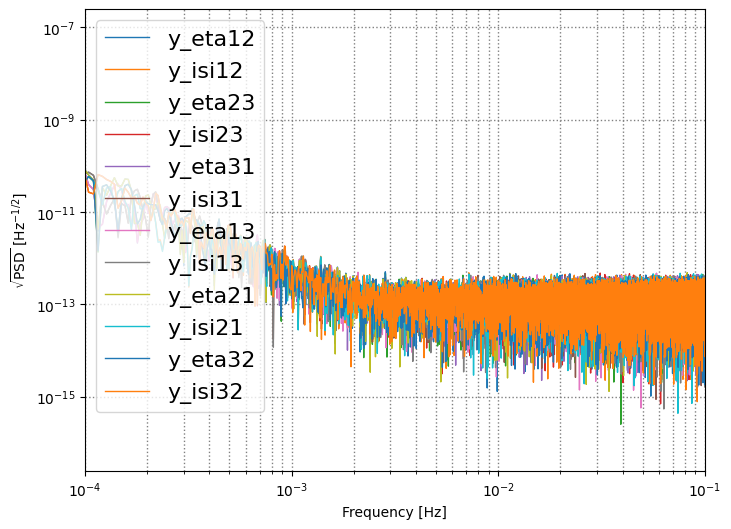

/bin/bash: /data/spack/opt/spack/linux-ubuntu20.04-skylake_avx512/gcc-9.4.0/anaconda3-2021.05-ch4zgln24uzwnqh2elmcfs6dkfuevuey/lib/libtinfo.so.6: no version information available (required by /bin/bash)
              total        used        free      shared  buff/cache   available
Mem:       15911324     3719224    10065856        1260     2126244    11890860
Swap:             0           0           0


In [66]:
import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 spectrum
for i in range(len(mosas_order)):
    axes.loglog(f[ipos], np.abs(y_fft[i][ipos]), 
            label='y_eta'+mosas_order[i], linewidth=1)
    axes.loglog(f[ipos], np.abs(y_isi_fft[i][ipos]), 
            label='y_isi'+mosas_order[i], linewidth=1)

axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"$\mathrm{\sqrt{PSD}}$ [$\mathrm{Hz^{-1/2}}$]")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
axes.set_xlim([1e-4, 1e-1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
plt.show()
!free

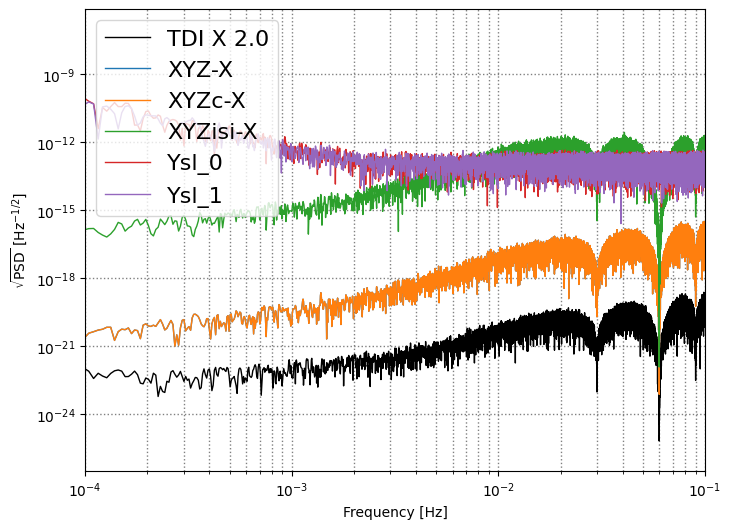

/bin/bash: /data/spack/opt/spack/linux-ubuntu20.04-skylake_avx512/gcc-9.4.0/anaconda3-2021.05-ch4zgln24uzwnqh2elmcfs6dkfuevuey/lib/libtinfo.so.6: no version information available (required by /bin/bash)
              total        used        free      shared  buff/cache   available
Mem:       15911324     3890416     9894660        1260     2126248    11719668
Swap:             0           0           0


In [67]:
import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 spectrum
axes.loglog(f[ipos], np.abs(x2_fft[ipos]), 
            label='TDI X 2.0', 
            color='black', linewidth=1)

axes.loglog(f[ipos], np.abs(XYZ_fft[0][ipos]), 
            label='XYZ-X', linewidth=1)
axes.loglog(f[ipos], np.abs(XYZc_fft[0][ipos]), 
            label='XYZc-X', linewidth=1)
axes.loglog(f[ipos], np.abs(XYZ_isi_fft[0][ipos]), 
            label='XYZisi-X', linewidth=1)

axes.loglog(f[ipos], np.abs(Ysl0_fft[ipos]), 
            label='Ysl_0', linewidth=1)
axes.loglog(f[ipos], np.abs(Ysl1_fft[ipos]), 
            label='Ysl_1', linewidth=1)

axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"$\mathrm{\sqrt{PSD}}$ [$\mathrm{Hz^{-1/2}}$]")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
axes.set_xlim([1e-4, 1e-1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
plt.show()
!free

It looks like the XYZ and XYZc are at least nearly doing the right thing.  The performance deficit vs the formal TDI may be because we are using a constant stencil produced from the initial time.  This is supported by the evidence that the is about 300 on 12 hrs of data but only about 30 on 1/2 hr of data.  

Let's see what happens with a time varying implementation.